In [2]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose
from torch_geometric.data import Data

import os,sys

sys.path.append(os.path.join(os.getcwd(), '..', 'tools'))

import argparse
import matplotlib.pyplot as plt
from training.models import GATRegressor, GraphSAGEModel, MPLNNRegressor
from training.transformations import DropLastTwoNodeFeatures,NormalizeNodeFeatures,NormalizeEdgeFeatures,NormalizeTargets
import pickle

import itertools

Initializing tools.training package


In [3]:
## This are the configuration of all the parameters

ModelOutDIR = "TEST_ELENA/"
BatchSize = 1024
LearningRate = 0.0005
Epochs = 500

In [5]:
## check if EOS folder exists otherwise use local folder
if os.path.exists("/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"):
    GraphDIR = "/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"
else:
    GraphDIR = "../../data/"

graph_name = 'vix_graph_13Nov_3_muonQOverPt' #"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
#"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
num_files = 20
Allgraphs = []
all_files = os.listdir(GraphDIR)

# Filter for .pkl files
graph_files = [f for f in all_files if (f.endswith('.pkl') or f.endswith('.pt')) and graph_name in f]
if not graph_files:
    print("No .pkl/.pt files found in the directory.")
    sys.exit()

graph_files = graph_files[:num_files]

graphs = []
for graph_file in graph_files:
    file_path = os.path.join(GraphDIR, graph_file)
    print(f"Loading file: {graph_file}")
    if graph_file.endswith('.pt'):
        graph = torch.load(file_path)
    elif graph_file.endswith('.pkl'):
        with open(file_path, 'rb') as file:
            graph = torch.load(file)
    graphs.append(graph)


Loading file: vix_graph_13Nov_3_muonQOverPt_006.pt


/var/folders/08/4qyj2h792lv7kk8b3phm_j000000gn/T/ipykernel_19190/2737031272.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(file_path)


Loading file: vix_graph_13Nov_3_muonQOverPt_002.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_003.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_007.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_008.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_009.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_004.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_005.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_001.pt


## Load data

In [6]:
Graphs_for_training = sum(graphs, [])
print(f"Total Graphs: {len(Graphs_for_training)}")

### NOW FILTER EMPTY GRAPHS... 
Graphs_for_training_reduced = Graphs_for_training
Graphs_for_training_filtered = [
    g for g in Graphs_for_training_reduced
    if not (torch.isnan(g.y).any() or torch.isnan(g.x).any())  and g.edge_index.size(1) > 0
]

# remove extra dimension in y and put deltaPhi and deltaEta in the data object as edge_attr
for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)        

Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]

print(f"Total Graphs: {len(Graphs_for_training)}")
print(f"Filtered Graphs: {len(Graphs_for_training_filtered)}")


Total Graphs: 507314
Total Graphs: 507314
Filtered Graphs: 502362


In [7]:
from torch_geometric.transforms import BaseTransform, Compose

class NormalizeNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)
        return data

class NormalizeEdgeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'edge_attr'):
            data.edge_attr = (data.edge_attr - data.edge_attr.mean(dim=0)) / data.edge_attr.std(dim=0)
        return data

class NormalizeTargets(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'y'):
            data.y = (data.y - data.y.mean(dim=0)) / data.y.std(dim=0)
        return data

class DropLastTwoNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = data.x[:, :-2]  # Eliminar las dos últimas columnas
        return data

class NormalizeSpecificNodeFeatures(BaseTransform):
    def __init__(self, column_indices):
        self.column_indices = column_indices

    def __call__(self, data):
        if hasattr(data, 'x'):
            for column_index in self.column_indices:
                column = data.x[:, column_index]
                mean = column.mean()
                std = column.std()
                data.x[:, column_index] = (column - mean) / std
        return data

# Definir las transformaciones
NormalizeNodeEdgesAndDropTwoFeatures = Compose([
    NormalizeNodeFeatures(),
    NormalizeEdgeFeatures(),
    DropLastTwoNodeFeatures()  # Aplicar la transformación para eliminar las dos últimas características
])

# Aplicar las transformaciones a los datos
Graphs_for_training_filtered = [NormalizeNodeEdgesAndDropTwoFeatures(data) for data in Graphs_for_training_filtered]

Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]

print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")

print("====================================")
print("Example of (transformed) data:")
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].edge_attr)
#print(Graphs_for_training_filtered[0].edge_weight)
print(Graphs_for_training_filtered[0].y)
print("====================================")

Total Graphs after filtering: 485446
Example of (transformed) data:
tensor([[-1.5275,  1.7185, -0.7298],
        [ 1.0911, -0.7405, -0.7765],
        [-0.2182, -0.5992, -0.6829],
        [ 0.6547, -0.0057,  1.1248],
        [ 0.0000, -0.3731,  1.0644]], dtype=torch.float64)
tensor([[0, 0, 1, 1, 2, 2, 3, 4],
        [1, 2, 0, 2, 0, 1, 4, 3]])
tensor([[-0.9804,  1.2748],
        [-0.8657,  0.4903],
        [-0.9804,  1.2748],
        [ 1.1295, -1.0786],
        [-0.8657,  0.4903],
        [ 1.1295, -1.0786],
        [ 0.7167, -0.6864],
        [ 0.7167, -0.6864]])
tensor([-0.0836])


In [8]:
# Load data
events = len(Graphs_for_training_filtered)
ntrain = int((events * 0.7) / BatchSize) * BatchSize  # to have full batches
print(f"Training events: {ntrain}")

train_dataset = Graphs_for_training_filtered[:ntrain]
test_dataset = Graphs_for_training_filtered[ntrain:ntrain * 2]

train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

Training events: 338944


### Validate graphs

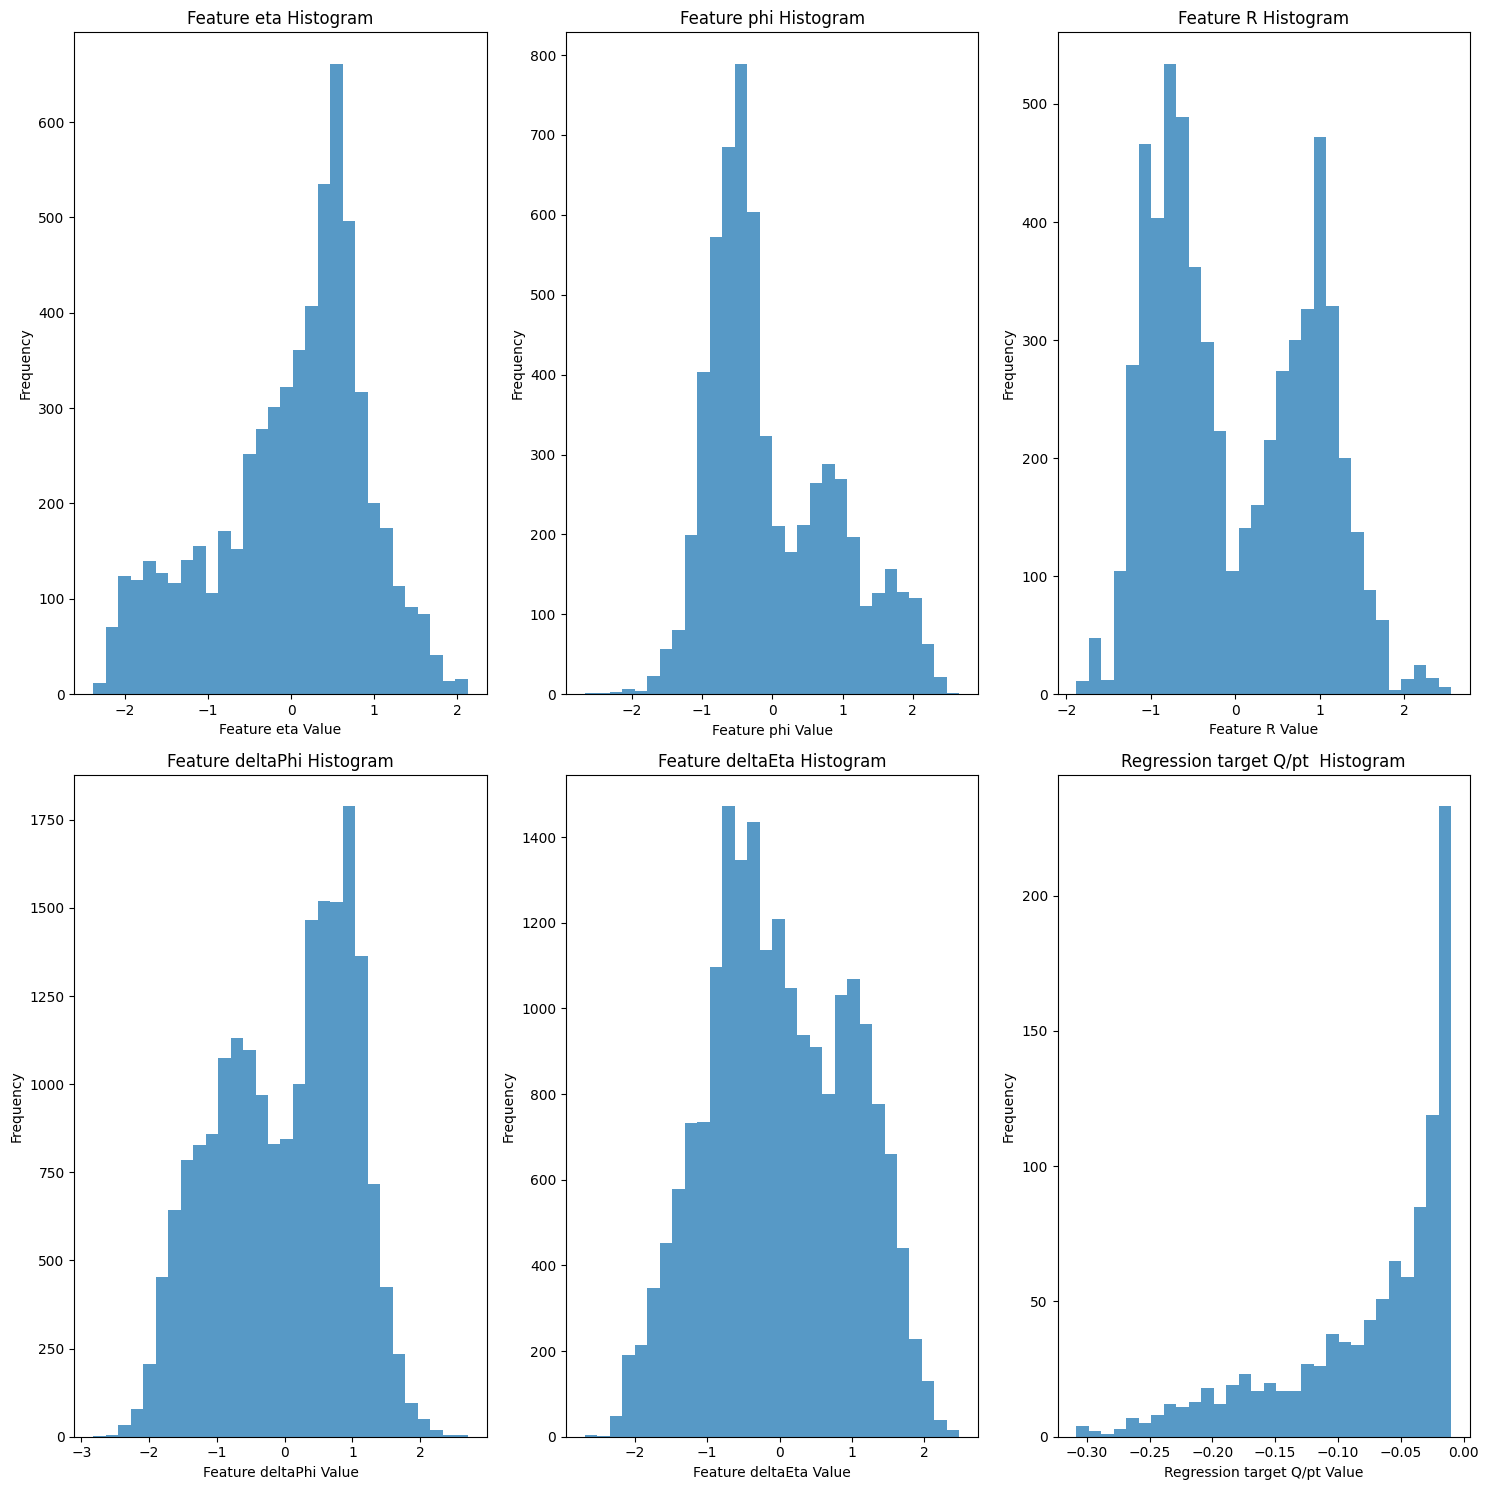

In [9]:
import matplotlib.pyplot as plt

# Function to plot histograms for each feature in the same figure

def plot_histograms(data_loader):   
    feature_names = ["eta", "phi", "R",  "deltaPhi", "deltaEta","Q/pt"]
    for batch in data_loader:
        features = batch.x.numpy()
        regression = batch.y.numpy()
        num_features = features.shape[1]
        fig, axs = plt.subplots(2, 3, figsize=(15, 15))
        axs = axs.flatten()
        
        # Plot node features
        for i in range(num_features):
            axs[i].hist(features[:, i], bins=30, alpha=0.75)
            axs[i].set_title(f'Feature {feature_names[i]} Histogram')
            axs[i].set_xlabel(f'Feature {feature_names[i]} Value')
            axs[i].set_ylabel('Frequency')
        
        
        # plot the number of edges of each graph
        for i in range(batch.edge_attr.shape[1]):
            axs[i+num_features].hist(batch.edge_attr[:, i], bins=30, alpha=0.75)
            axs[i+num_features].set_title(f'Feature {feature_names[i+num_features]} Histogram')
            axs[i+num_features].set_xlabel(f'Feature {feature_names[i+num_features]} Value')
            axs[i+num_features].set_ylabel('Frequency')
        
        # Plot regression target
        axs[num_features + (batch.edge_attr.shape[1])].hist(regression, bins=30, alpha=0.75)
        axs[num_features + (batch.edge_attr.shape[1])].set_title(f'Regression target {feature_names[-1]}  Histogram')
        axs[num_features + (batch.edge_attr.shape[1])].set_xlabel(f'Regression target {feature_names[-1]} Value')
        axs[num_features + (batch.edge_attr.shape[1])].set_ylabel('Frequency')
              
        plt.tight_layout()
        plt.show()
        break  # Only draw the first batch

# Plot histograms for training data
plot_histograms(train_loader)

## Train model

In [10]:
num_node_features = 3
hidden_dim = 32
output_dim = 1 ## ONE FEATURE ONLY!!!


# Definir el modelo, optimizador y la función de pérdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GATRegressor = GATRegressor(num_node_features=num_node_features, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model_GATRegressor.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
print(model_GATRegressor)


GATRegressor(
  (conv1): GATConv(3, 32, heads=1)
  (conv2): GATConv(32, 32, heads=1)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [11]:
# Definir una función para entrenar el modelo
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Definir una función para evaluar el modelo
@torch.no_grad()
def test_model(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        total_loss += loss.item()
    return total_loss / len(test_loader)


In [12]:
# Entrenar y evaluar el modelo
num_epochs = 10
for epoch in range(num_epochs):

    GAT_train_loss = train_model(model_GATRegressor, train_loader, optimizer, loss_fn, device)
    GAT_test_loss = test_model(model_GATRegressor, test_loader, loss_fn, device)

    # Print the loss for each epoch, in a table of all models: 
    print(f'Epoch {epoch+1:3d}/{num_epochs:3d}, GAT Loss: {GAT_train_loss:.4f} ({GAT_test_loss:.4f})')


Epoch   1/ 10, GAT Loss: 0.0053 (0.0038
Epoch   2/ 10, GAT Loss: 0.0037 (0.0036
Epoch   3/ 10, GAT Loss: 0.0035 (0.0034
Epoch   4/ 10, GAT Loss: 0.0034 (0.0033
Epoch   5/ 10, GAT Loss: 0.0033 (0.0032
Epoch   6/ 10, GAT Loss: 0.0032 (0.0032
Epoch   7/ 10, GAT Loss: 0.0032 (0.0031
Epoch   8/ 10, GAT Loss: 0.0031 (0.0031
Epoch   9/ 10, GAT Loss: 0.0031 (0.0030
Epoch  10/ 10, GAT Loss: 0.0031 (0.0030


In [13]:
# Save the model
if not os.path.exists(ModelOutDIR):
    os.makedirs(ModelOutDIR)

torch.save(model_GATRegressor.state_dict(), f'{ModelOutDIR}model_GATRegressor_{BatchSize}batches_{num_epochs}epochs_3_32_32_1.pt')

## Validate model

In [14]:
## Plot the results
import numpy as np

def remove_outliers(data, m=1.5):
    data = np.array(data)
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    return data[modified_z_score < m]

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    all_regression = []
    all_prediction = []
    with torch.no_grad():
        for data in test_loader:
            #only one batch
            data = data.to(device)
            out = model(data)
            all_regression.append(data.y.cpu().numpy())
            all_prediction.append(out.cpu().numpy())
    
    
    # Concatenar todas las predicciones y valores objetivo
    all_regression = np.concatenate(all_regression, axis=0)
    all_prediction = np.concatenate(all_prediction, axis=0)
    
    return all_regression, all_prediction

regression_list = []
prediction_list = []

for model in [model_GATRegressor]:
    print(f'Evaluating model {model}')
    regression, prediction = evaluate_model(model, test_loader, device)
    regression_list.append((regression))
    prediction_list.append((prediction))


Evaluating model GATRegressor(
  (conv1): GATConv(3, 32, heads=1)
  (conv2): GATConv(32, 32, heads=1)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


In [18]:
def plot_results(all_regression, all_prediction, label='Model'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    print("Plotting Regression target")
    axs[0].hist(all_regression, bins=np.arange(-0.5,0,0.006), alpha=0.75, label='Regression target')
    axs[0].hist(all_prediction, bins=np.arange(-0.5,0,0.006), alpha=0.75, label='Prediction')
    axs[0].set_title(f'Regression target and prediction for {label}')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    axs[1].scatter(all_regression, all_prediction, alpha=0.5)
    axs[1].set_title(f'Regression target vs prediction for {label}')
    axs[1].set_xlabel('Regression target')
    axs[1].set_ylabel('Prediction')

    plt.tight_layout()
    plt.show()



Plotting results for model: GAT
Plotting Regression target


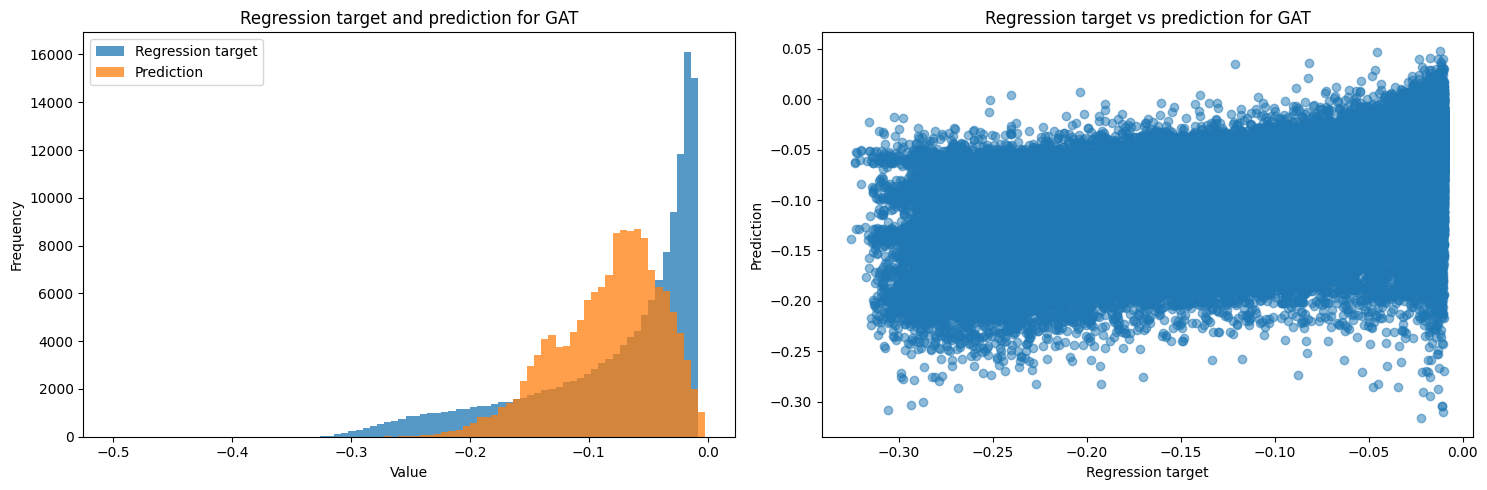

In [19]:
labels = ['GAT']

for i in range(len(labels)): 
    print(f'Plotting results for model: {labels[i]}')
    plot_results(regression_list[i], prediction_list[i], label=labels[i])